# Load Dependencies

In [1]:
import pandas as pd, pprint, sys, requests, numpy as np, matplotlib.pyplot as plt
import json, re, ast
import seaborn as sns
plt.style.use('ggplot')
import os

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from pysal.lib import examples
from osgeo import gdal
gdal.SetConfigOption('SHAPE_RESTORE_SHX', 'YES')



C:\Users\wonch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\wonch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
C:\Users\wonch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\wonch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\libpysal\cg\alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will

# Variables

In [30]:
path = 'C:/Users/wonch/OneDrive/Escritorio/Projects/Prueba Tecnica DD360/reto1/'
raw_csv = path+'raw_data/reto_precios.csv'

In [31]:
path = 'C:/Users/wonch/OneDrive/Escritorio/Projects/Prueba Tecnica DD360/reto1/'
raw_csv = path+'raw_data/reto_precios.csv'
cdmx_shape = path+'cdmx_map/nyu_2451_36855.shp'
alcaldias_shape = path+'poligonos_alcaldias_cdmx/poligonos_alcaldias_cdmx.shp'
alcaldiasv2_shape = path+'poligonos_alcaldias_cdmx_update/poligonos_alcaldias_cdmx.shp'
ageb_shape = path+'poligono_ageb_urbanas_cdmx/poligono_ageb_urbanas_cdmx.shp'
ids_ageb = path+'raw_data/ids_ageb.csv'

# Data INEGI

INEGI Data containing DENUE and AGEBs information
Using INEGIpy library for ease of access to INEGI API *(https://github.com/andreslomeliv/DatosMex/tree/master/INEGIpy#AGEBs)*

In [32]:
from INEGIpy import MarcoGeoestadistico
marco = MarcoGeoestadistico()
cdmx = '09'
alcaldias = ['015','014','016','010']

In [33]:
type(marco.AGEBs(claves_concatenadas=cdmx+alcaldias[1]))

geopandas.geodataframe.GeoDataFrame

In [34]:
df_agebs = gpd.GeoDataFrame()
for i in alcaldias:
  ageb = marco.AGEBs(claves_concatenadas=cdmx+i)
  df_agebs = pd.concat([df_agebs,ageb])

# Data Wrangling

In [35]:
df = pd.read_csv(raw_csv)

In [18]:
df.shape

(981, 35)

In [19]:
df.columns

Index(['main_name', 'subtitle', 'link', 'location', 'price', 'attributes',
       'timestamp', 'id', 'address', 'since', 'description', 'vendor', 'lat',
       'lon', 'price_mod', 'price_currency', 'since_period', 'since_value',
       'days_on_site', 'amenities', 'age_in_years', 'bathrooms', 'cellars',
       'num_floors', 'monthly_fee', 'apartments_per_floor', 'disposition',
       'parking_lots', 'floor_situated', 'orientation', 'num_bedrooms',
       'department_type', 'm2', 'final_price', 'price_square_meter'],
      dtype='object')

In [20]:
df.head(3)

,main_name,subtitle,link,location,price,attributes,timestamp,id,address,since,...,apartments_per_floor,disposition,parking_lots,floor_situated,orientation,num_bedrooms,department_type,m2,final_price,price_square_meter
0,Departamento - Roma Norte,Departamento en venta,https://departamento.metroscubicos.com/MLM-139...,"Sinaloa 20 , Roma Sur, Roma Sur, Cuauhtémoc, D...",9000000 pesos,"127 m² construidos,2 recs.",2022-03-29,1,"Sinaloa 20 , Roma Sur",Publicado hace 5 días,...,NaN,Contrafrente,2,NaN,NaN,2.0,NaN,127.0,9000000.0,70866.141732
1,Preventa Exclusiva · Terraloza Roma Norte ·,Departamento en venta,https://departamento.metroscubicos.com/MLM-139...,"Tonala, Roma Norte, Cuauhtémoc, Distrito Federal",4264000 pesos,"54 m² construidos,1 rec.",2022-03-29,2,Tonala,Publicado hace 7 días,...,NaN,NaN,1,NaN,NaN,1.0,NaN,54.0,4264000.0,78962.962963
2,Townhouse Único En La Roma Sur,Departamento en venta,https://departamento.metroscubicos.com/MLM-139...,"Tepeji 43, Roma Sur, Ciudad De México, Cdmx, M...",8093500 pesos,"163 m² construidos,3 recs.",2022-03-29,3,"Tepeji 43, Roma Sur, Ciudad De México, Cdmx, M...",Publicado hace 4 días,...,NaN,NaN,2,NaN,NaN,3.0,NaN,163.0,8093500.0,49653.374233


In [21]:
df[['lat','lon']].describe()

,lat,lon
count,981.000000,981.000000
mean,19.654796,-99.222834
std,1.244009,0.608650
min,19.360533,-117.063962
25%,19.405824,-99.165172
50%,19.411515,-99.163637
75%,19.419526,-99.161332
max,32.528726,-99.128642


#Ample deveation on latitude and longitude columns min and max decimal degrees variate greatly so the coordinates are very far appart from each other.
#### For easy manipulation plot the data and see where they're geographically located

<Axes: >

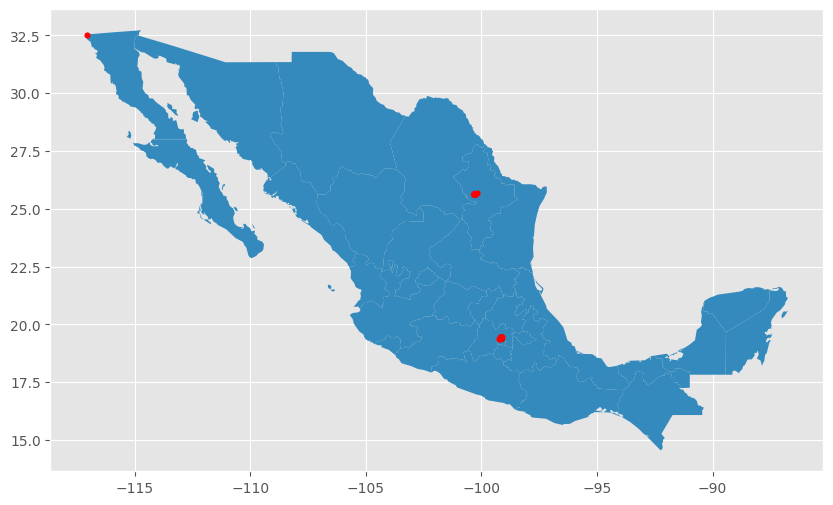

In [22]:
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf = GeoDataFrame(df, geometry=geometry)
world = gpd.read_file(examples.get_path("mexicojoin.shp"))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15)

# Not everything is in CDMX - There are stuff in TJ and MTY.
### Hence there's a hardcut at lat > -100 and lon < 20 for accurate data manipulation

In [23]:
df_cdmx = df[(df['lat']>-100)&(df['lat']<20)]

<Axes: >

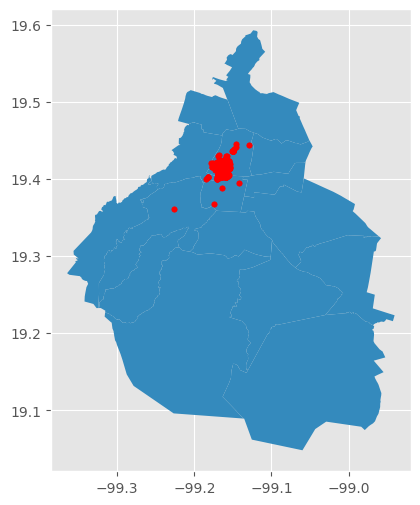

In [24]:
geometry = [Point(xy) for xy in zip(df_cdmx['lon'], df_cdmx['lat'])]
gdf = GeoDataFrame(df_cdmx, geometry=geometry)
world = gpd.read_file(alcaldias_shape)
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15)

<Axes: >

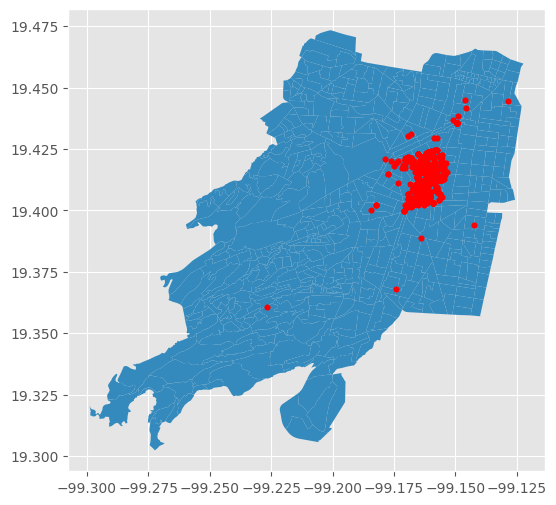

In [25]:
geometry = [Point(xy) for xy in zip(df_cdmx['lon'], df_cdmx['lat'])]
gdf = GeoDataFrame(df_cdmx, geometry=geometry)
gdf.plot(ax=df_agebs.plot(figsize=(10, 6)), marker='o', color='red', markersize=15)

<Axes: >

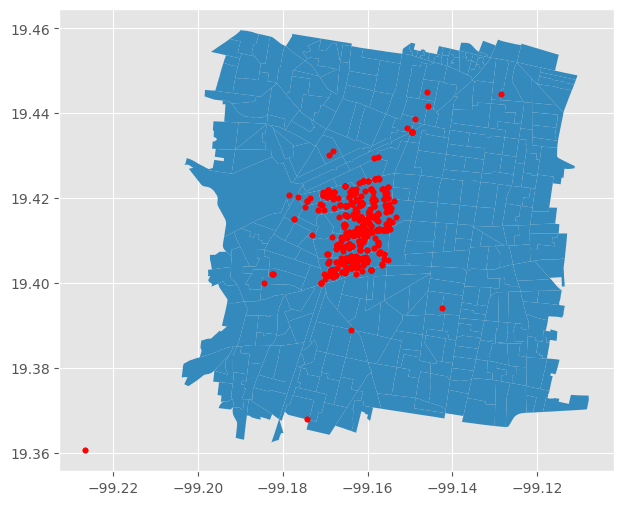

In [26]:
geometry = [Point(xy) for xy in zip(df_cdmx['lon'], df_cdmx['lat'])]
gdf = GeoDataFrame(df_cdmx, geometry=geometry)
world = gpd.read_file(ageb_shape)
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15)

# Alcaldías where the properties are located:


*   Cuahutemoc
*   Benito Juarez<sup>*</sup>
*   Miguel Hidalgo<sup>*</sup>
*   Alvaro Obregon<sup>**</sup>

<sup>*</sup>A scattered set of properties in these areas, might bring noise but relevant for statistical significancy. \
<sup>**</sup>This property could be potentially treated like an outlier, it's pretty far away from the rest of the cities and might cause noise when analyzing.

*Pública, A. D. de I. (n.d.). Portal de Datos Abiertos de la CDMX. https://datos.cdmx.gob.mx/dataset/alcaldias/resource/8648431b-4f34-4f1a-a4b1-19142f944300*

In [27]:
df_agebs

,geometry,cve_agee,nom_agee,cve_agem,nom_agem,cve_loc,cvegeo,pobtot,pobmas,pobfem,tvivhab,cve_ageb
0,"MULTIPOLYGON (((-99.13836 19.45473, -99.13836 ...",09,Distrito Federal,015,Cuauhtémoc,0001,0901500010273,594,283,311,230,0273
1,"MULTIPOLYGON (((-99.13660 19.45347, -99.13668 ...",09,Distrito Federal,015,Cuauhtémoc,0001,0901500010288,235,120,115,92,0288
2,"MULTIPOLYGON (((-99.13360 19.45323, -99.13369 ...",09,Distrito Federal,015,Cuauhtémoc,0001,0901500010305,1377,642,735,555,0305
3,"MULTIPOLYGON (((-99.15939 19.41688, -99.15937 ...",09,Distrito Federal,015,Cuauhtémoc,0001,0901500011106,1552,800,752,744,1106
4,"MULTIPOLYGON (((-99.13266 19.45303, -99.13292 ...",09,Distrito Federal,015,Cuauhtémoc,0001,090150001031A,1351,620,731,545,031A
...,...,...,...,...,...,...,...,...,...,...,...,...
194,"MULTIPOLYGON (((-99.20039 19.38230, -99.20207 ...",09,Distrito Federal,010,Álvaro Obregón,0001,0901000012108,3889,1870,2019,788,2108
195,"MULTIPOLYGON (((-99.27195 19.31512, -99.27187 ...",09,Distrito Federal,010,Álvaro Obregón,0001,0901000011754,3230,1586,1644,850,1754
196,"MULTIPOLYGON (((-99.24935 19.32721, -99.24966 ...",09,Distrito Federal,010,Álvaro Obregón,0001,0901000012057,3669,1757,1912,1009,2057
197,"MULTIPOLYGON (((-99.24692 19.35727, -99.24705 ...",09,Distrito Federal,010,Álvaro Obregón,0001,0901000012216,4171,2025,2146,995,2216


In [28]:
from INEGIpy import DENUE
token_inegi = '6b85b69a-8be5-cd14-bb48-f5a35a35dbf9'
denue = DENUE(token_inegi)

In [29]:
denue.Buscar('hotel', latitud = 19.32593, longitud = -99.17253, distancia = 3_000)

ConnectionError: ('Connection aborted.', BadStatusLine('HTTP/1.1 000 \r\n'))